In [23]:
import time
import sys
import pathlib
import os
import numpy as np
import cv2 as cv
from spatialmath import SE3
from scipy.spatial.transform import Rotation as R, Slerp
import matplotlib.pyplot as plt
from roboticstoolbox import DHRobot, RevoluteDH
from spatialmath.base import trotx, troty, trotz
from spatialmath.base.transforms3d import eul2jac
import csv
import pathlib
import roboticstoolbox as rtb

notebook_path = os.getcwd()
sys.path.append(str(pathlib.Path(notebook_path).parent))
from classrobot.robot_movement import RobotControl
from classrobot.realsense_cam import RealsenseCam
from classrobot.UR5e_DH import UR5eDH



In [24]:
HOME_POS = [0.701172053107018, 0.184272460738082, 0.1721568294843568, 
            -1.7318488600590023, 0.686830145115122, -1.731258978679887]

HOME_POS_JOINTS = [0.7144814729690552, -1.9380423031248988, -2.0520365238189697,
                   -2.2719952068724574, -0.9003556410418909, 2.3653483390808105]
GOAL = [0.8256127266378359, 0.12745803218842616, -0.13050644122642596, 
        -1.7318443587261685, 0.686842056802218, -1.7312759524010408]

RPY = [-1.7318443587261685, 0.686842056802218, -1.7312759524010408]
RPY_test =  [-1.7224438319206319, 0.13545161633255984, -1.2975236351897372]

## Function trajectory planning


In [25]:
class Planning:

    def __init__(self, dt=0.01):
        self.dt = dt


    def rottraj_py(self,R0, RF, time_interval, t, time_scaling=None):
        """
        Python equivalent of MATLAB rottraj.
        
        Parameters:
        R0, RF         : initial and final orientations. Can be:
                        - scipy R object,
                        - 3x3 R matrix,
                        - length-4 quaternion [x, y, z, w].
        time_interval : length-2 sequence [t0, t1].
        t              : length-M array of sample times.
        time_scaling   : optional 3xM array [s; sd; sdd] time-scaling
                        (default linear).
        
        Returns:
        R_mats         : array shape (M,3,3) of R matrices.
        omega          : array shape (3, M) angular velocities (rad/s).
        alpha          : array shape (3, M) angular accelerations (rad/s^2).
        """
        t = np.asarray(t)
        t0, t1 = time_interval
        # Convert inputs to R
        def to_rot(r):
            if isinstance(r, R):
                return r
            a = np.asarray(r)
            if a.shape == (3,3):
                return R.from_matrix(a)
            elif a.shape == (4,):
                return R.from_quat(a)
            else:
                raise ValueError("R0/RF must be R, 3x3 matrix or 4-element quaternion")
        rot0 = to_rot(R0)
        rotF = to_rot(RF)
        
        M = len(t)
        # Time scaling
        if time_scaling is None:
            # linear from 0→1
            s   = (t - t0) / (t1 - t0)
            sd  = np.full(M, 1.0/(t1 - t0))
            sdd = np.zeros(M)
        else:
            ts = np.asarray(time_scaling)
            s, sd, sdd = ts[0], ts[1], ts[2]
        
        # Slerp at normalized times s
        key_times = [0.0, 1.0]
        slerp_norm = Slerp(key_times, R.concatenate([rot0, rotF]))
        R_samp = slerp_norm(s)  # Rotation object length M
        
        # Build rotation matrices array (M,3,3)
        R_mats = R_samp.as_matrix()
        
        # Compute angular velocity omega: forward difference
        omega = np.zeros((M,3))
        for k in range(M-1):
            Rk_inv = R_samp[k].inv()
            deltaR = Rk_inv * R_samp[k+1]
            rotvec = deltaR.as_rotvec()  # axis*angle
            dt = t[k+1] - t[k]
            omega[k] = rotvec / dt
        omega[-1] = omega[-2]
        
        # Angular acceleration alpha: finite difference of omega
        alpha = np.zeros((M,3))
        for k in range(1, M):
            dt = t[k] - t[k-1]
            alpha[k] = (omega[k] - omega[k-1]) / dt
        alpha[0] = alpha[1]
        
        return R_mats, omega.T, alpha.T  # omega,alpha as (3,M) arrays

    def compute_traj_time_v2(self, d, v_tool, a_max):
        if d < 0:
            raise ValueError("Distance must be non-negative")
        if v_tool <= 0 or a_max <= 0:
            raise ValueError("v_tool and a_max must be > 0")
        d_ramps = v_tool**2 / a_max
        if d <= d_ramps:
            t_accel = np.sqrt(d / a_max)
            t_const = 0.0
            t_decel = t_accel
            profile = 'Triangular'
        else:
            t_accel = v_tool / a_max
            t_const = (d - d_ramps) / v_tool
            t_decel = t_accel
            profile = 'Trapezoidal'
        T_total = t_accel + t_const + t_decel
        return T_total, profile, t_accel, t_const, t_decel

    def generate_cubic_coeffs(self, p0, p1, v0, v1, T):
        """
        Solve for cubic coefficients a, b such that:
        p(t)   = a*t^3 + b*t^2 + v0*t + p0
        p'(t)  = 3a*t^2 + 2b*t + v0
        with boundary conditions at t=0: p(0)=p0, p'(0)=v0
                        at t=T: p(T)=p1, p'(T)=v1
        """
        a = (2*(p0 - p1) + (v0 + v1)*T) / (T**3)
        b = (3*(p1 - p0) - (2*v0 + v1)*T) / (T**2)
        return a, b

    def cubicpolytraj(self, waypoints, timepoints, t, vel_bc=None):
        """
        Multi-segment cubic trajectory for translation only.

        waypoints:  (n, P) array of P waypoints in n dims
        timepoints: length-P array of cumulative times
        t:          length-M sample times
        vel_bc:     optional (n, P) boundary velocities (defaults zero)
        """
        waypoints  = np.asarray(waypoints)
        timepoints = np.asarray(timepoints)
        t          = np.asarray(t)
        n, P       = waypoints.shape

        if vel_bc is None:
            vel_bc = np.zeros((n, P))
        else:
            vel_bc = np.asarray(vel_bc)

        # Preallocate
        M   = len(t)
        q   = np.zeros((n, M))
        qd  = np.zeros((n, M))
        qdd = np.zeros((n, M))

        # Build segment info
        segments = []
        for i in range(P-1):
            Tseg = timepoints[i+1] - timepoints[i]
            p0, p1 = waypoints[:,i], waypoints[:,i+1]
            v0, v1 = vel_bc[:,i], vel_bc[:,i+1]
            a, b   = self.generate_cubic_coeffs(p0, p1, v0, v1, Tseg)
            segments.append({
                't0': timepoints[i],
                't1': timepoints[i+1],
                'p0': p0, 'v0': v0,
                'a': a,   'b': b
            })

        # Evaluate at each sample
        for idx, tk in enumerate(t):
            # before start or after end
            if tk <= segments[0]['t0']:
                q[:,idx] = waypoints[:,0]
            elif tk >= segments[-1]['t1']:
                q[:,idx] = waypoints[:,-1]
            else:
                # in between
                for seg in segments:
                    if seg['t0'] <= tk <= seg['t1']:
                        τ = tk - seg['t0']
                        a, b, v0, p0 = seg['a'], seg['b'], seg['v0'], seg['p0']
                        q[:,idx]   =   a*τ**3 +   b*τ**2 + v0*τ + p0
                        qd[:,idx]  = 3*a*τ**2 + 2*b*τ    + v0
                        qdd[:,idx] = 6*a*τ     + 2*b
                        break

        return q, qd, qdd, segments
    
    def cubic_trajectory(self, p0, p1, v0, v1, T):
        p0, p1, v0, v1 = map(np.array, (p0, p1, v0, v1))
        num_steps = int(np.ceil(T / self.dt)) + 1
        t = np.linspace(0, T, num_steps).reshape(-1, 1)
        a = (2 * (p0 - p1) + (v0 + v1) * T) / (T ** 3)
        b = (3 * (p1 - p0) - (2 * v0 + v1) * T) / (T ** 2)
        pos = a * t**3 + b * t**2 + v0 * t + p0
        vel = 3 * a * t**2 + 2 * b * t + v0
        acc = 6 * a * t + 2 * b
        return t.flatten(), pos, vel, acc

    def cubic_trajectory_v1(self, p0, p1, v0, v1, T, dt):
        # ensure numpy arrays
        p0, p1, v0, v1 = map(np.asarray, (p0, p1, v0, v1))
        # time vector
        t = np.arange(0, T + 1e-8, dt)        # include T
        ts = t.reshape(-1, 1)                 # for broadcasting
        
        # coefficients
        a0 = p0
        a1 = v0
        a2 =  3*(p1 - p0)/T**2 - (2*v0 + v1)/T
        a3 = -2*(p1 - p0)/T**3 + (v0 + v1)/T**2
        
        # evaluate
        pos = a0 + a1*ts + a2*ts**2 + a3*ts**3
        vel =      a1   + 2*a2*ts   + 3*a3*ts**2
        acc =           2*a2       + 6*a3*ts

        return t.flatten(), pos, vel, acc

    
    def cubic_trajectory_v2(self, p0, p1, v0, v1, q0, q1, T):

        # --- Translation (cubic) ---
        p0, p1, v0, v1 = map(np.array, (p0, p1, v0, v1))
        num_steps = int(np.ceil(T / self.dt)) + 1
        t = np.linspace(0, T, num_steps).reshape(-1, 1)

        a = (2 * (p0 - p1) + (v0 + v1) * T) / (T ** 3)
        b = (3 * (p1 - p0) - (2 * v0 + v1) * T) / (T ** 2)

        pos = a * t**3 + b * t**2 + v0 * t + p0
        vel = 3 * a * t**2 + 2 * b * t + v0
        acc = 6 * a * t + 2 * b

        # --- Orientation (SLERP) ---
        # Normalize quaternions
        q0 = np.asarray(q0) / np.linalg.norm(q0)
        q1 = np.asarray(q1) / np.linalg.norm(q1)

        # Build SLERP object
        key_rots = R.from_quat([q0, q1])
        slerp = Slerp([0.0, 1.0], key_rots)

        # Normalize time to [0,1]
        tau = t.flatten() / T

        # Interpolate orientations
        orients = slerp(tau).as_quat()

        return t.flatten(), pos, vel, acc, orients
    

    def cubic_trajectory_v3(self, p0, p1, v0, v1, rpy0, rpy1, T):
        """
        Generate a cubic (3rd-order) trajectory for translation and SLERP for orientation,
        using RPY inputs and returning RPY outputs.

        Parameters:
        -----------
        p0   : array_like, shape (3,)
               Start position [x, y, z]
        p1   : array_like, shape (3,)
               End position [x, y, z]
        v0   : array_like, shape (3,)
               Start velocity [vx, vy, vz]
        v1   : array_like, shape (3,)
               End velocity [vx, vy, vz]
        rpy0 : array_like, shape (3,)
               Start orientation as roll, pitch, yaw (rad)
        rpy1 : array_like, shape (3,)
               End orientation as roll, pitch, yaw (rad)
        T    : float
               Total trajectory time

        Returns:
        --------
        t        : ndarray, shape (N,)
                   Time vector
        pos      : ndarray, shape (N,3)
                   Positions along the cubic trajectory
        vel      : ndarray, shape (N,3)
                   Velocities along the cubic trajectory
        acc      : ndarray, shape (N,3)
                   Accelerations along the cubic trajectory
        rpy_traj : ndarray, shape (N,3)
                   SLERP-interpolated roll, pitch, yaw angles (rad)
        """
        # Translation (cubic)
        p0, p1, v0, v1 = map(np.array, (p0, p1, v0, v1))
        num_steps = int(np.ceil(T / self.dt)) + 1
        t = np.linspace(0, T, num_steps).reshape(-1, 1)

        a = (2 * (p0 - p1) + (v0 + v1) * T) / (T ** 3)
        b = (3 * (p1 - p0) - (2 * v0 + v1) * T) / (T ** 2)

        pos = a * t**3 + b * t**2 + v0 * t + p0
        vel = 3 * a * t**2 + 2 * b * t + v0
        acc = 6 * a * t + 2 * b

        # Orientation (SLERP) with RPY I/O
        # Convert RPY to quaternions
        q0 = R.from_euler('xyz', rpy0, degrees=False).as_quat()
        q1 = R.from_euler('xyz', rpy1, degrees=False).as_quat()

        # Build SLERP
        key_rots = R.from_quat([q0, q1])
        slerp = Slerp([0.0, 1.0], key_rots)
        tau = t.flatten() / T

        # Interpolate and convert back to RPY
        quats = slerp(tau).as_quat()
        rpy_traj = R.from_quat(quats).as_euler('xyz', degrees=False)

        return t.flatten(), pos, vel, acc, rpy_traj
    
    def quintic_trajectory(self, p0, p1, v0, v1, q0, q1, T):
        """
        Generate a quintic (5th-order) SE(3) trajectory from p0 to p1 and q0 to q1
        with boundary conditions on position, velocity, and zero acceleration.
        
        Returns:
        t       – (N,) time vector
        pos     – (N, len(p0)) positions
        vel     – (N, len(p0)) velocities
        acc     – (N, len(p0)) accelerations
        orients – (N,4) quaternions (x,y,z,w)
        """
        # Ensure inputs are numpy arrays
        p0, p1, v0, v1 = map(np.array, (p0, p1, v0, v1))
        q0 = np.asarray(q0) / np.linalg.norm(q0)
        q1 = np.asarray(q1) / np.linalg.norm(q1)

        # Time vector
        num_steps = int(np.ceil(T / self.dt)) + 1
        t = np.linspace(0, T, num_steps)
        ts = t.reshape(-1, 1)

        # Quintic translation coefficients (zero accel endpoints)
        a0 = p0
        a1 = v0
        a2 = np.zeros_like(p0)

        # Powers of T
        T2, T3, T4, T5 = T**2, T**3, T**4, T**5

        # Solve for a3, a4, a5
        M = np.array([
            [   T3,    T4,    T5],
            [ 3*T2,  4*T3,  5*T4],
            [ 6*T , 12*T2, 20*T3]
        ])
        M_inv = np.linalg.inv(M)
        dp = p1 - p0
        rhs = np.vstack([
            dp - v0 * T,
            v1 - v0,
            np.zeros_like(p0)
        ])
        a3, a4, a5 = M_inv.dot(rhs)

        # Evaluate position, velocity, acceleration
        pos = a0 + a1*ts + a2*ts**2 + a3*ts**3 + a4*ts**4 + a5*ts**5
        vel =    a1 + 2*a2*ts   + 3*a3*ts**2 + 4*a4*ts**3 + 5*a5*ts**4
        acc =       2*a2       + 6*a3*ts     +12*a4*ts**2  +20*a5*ts**3

        return t, pos, vel, acc
    

    def quintic_trajectory_v2(self, p0, p1, v0, v1, rpy0, rpy1, T):
        """
        Generate a quintic (5th-order) SE(3) trajectory from p0 to p1
        and from rpy0 to rpy1, with boundary conditions on position,
        velocity, and zero acceleration.

        Parameters:
        -----------
        p0   : array_like, shape (3,)
               Start position [x, y, z]
        p1   : array_like, shape (3,)
               End position [x, y, z]
        v0   : array_like, shape (3,)
               Start velocity [vx, vy, vz]
        v1   : array_like, shape (3,)
               End velocity [vx, vy, vz]
        rpy0 : array_like, shape (3,)
               Start orientation as roll, pitch, yaw (rad)
        rpy1 : array_like, shape (3,)
               End orientation as roll, pitch, yaw (rad)
        T    : float
               Total trajectory duration (s)

        Returns:
        --------
        t       : ndarray, shape (N,)
                  Time vector
        pos     : ndarray, shape (N,3)
                  Positions along the quintic trajectory
        vel     : ndarray, shape (N,3)
                  Velocities along the quintic trajectory
        acc     : ndarray, shape (N,3)
                  Accelerations along the quintic trajectory
        rpy_traj: ndarray, shape (N,3)
                  Interpolated roll, pitch, yaw angles (rad)
        """
        # --- ensure array inputs ---
        p0, p1, v0, v1 = map(np.array, (p0, p1, v0, v1))
        rpy0 = np.array(rpy0)
        rpy1 = np.array(rpy1)

        # --- time vector ---
        num_steps = int(np.ceil(T / self.dt)) + 1
        t = np.linspace(0, T, num_steps)
        ts = t.reshape(-1, 1)

        # --- quintic translation ---
        a0 = p0
        a1 = v0
        a2 = np.zeros_like(p0)

        # Powers of T
        T2, T3, T4, T5 = T**2, T**3, T**4, T**5

        # Reduced system for a3, a4, a5
        M = np.array([
            [   T3,    T4,    T5],
            [ 3*T2,  4*T3,  5*T4],
            [ 6*T , 12*T2, 20*T3]
        ])
        rhs = np.vstack([
            (p1 - p0) - v0 * T,
            v1 - v0,
            np.zeros_like(p0)
        ])
        a3, a4, a5 = np.linalg.inv(M).dot(rhs)

        pos = a0 + a1*ts + a2*ts**2 + a3*ts**3 + a4*ts**4 + a5*ts**5
        vel =    a1 + 2*a2*ts   + 3*a3*ts**2 + 4*a4*ts**3 + 5*a5*ts**4
        acc =       2*a2       + 6*a3*ts     +12*a4*ts**2  +20*a5*ts**3

        # --- SLERP orientation from RPY ---
        # Convert RPY to quaternions
        q0 = R.from_euler('xyz', rpy0, degrees=False).as_quat()
        q1 = R.from_euler('xyz', rpy1, degrees=False).as_quat()

        # SLERP setup
        slerp = Slerp([0.0, 1.0], R.from_quat([q0, q1]))
        tau = t / T
        quats = slerp(tau).as_quat()  # array (N,4)

        # Convert back to RPY
        rpy_traj = R.from_quat(quats).as_euler('xyz', degrees=False)

        return t, pos, vel, acc, rpy_traj

    def slerp_orientation(t: np.ndarray, q0: np.array, q1: np.array, T: float) -> np.ndarray:
        """
        SLERP-interpolate between two unit quaternions over timestamps t.

        Parameters:
        -----------
        t  : array_like, shape (N,)
            Time samples (0 <= t_i <= T).
        q0 : array_like, shape (4,)
            Start quaternion (x, y, z, w).
        q1 : array_like, shape (4,)
            End quaternion (x, y, z, w).
        T  : float
            Total interpolation time.

        Returns:
        --------
        orients : ndarray, shape (N,4)
            Interpolated quaternions at each t[i].
        """
        t = np.asarray(t)
        if np.any(t < 0) or np.any(t > T):
            raise ValueError("All t values must lie within [0, T].")

        # Normalize input quaternions
        q0 = np.asarray(q0) / np.linalg.norm(q0)
        q1 = np.asarray(q1) / np.linalg.norm(q1)

        # Build SLERP object over [0,1]
        key_rots = R.from_quat([q0, q1])
        slerp = Slerp([0.0, 1.0], key_rots)

        # Normalize t to [0,1]
        tau = t / T

        # Compute SLERP and return as (x,y,z,w)
        return slerp(tau).as_quat()

    # def compute_traj_time(self, d, v_tool, a_max):
    #     if d < (v_tool ** 2) / a_max:
    #         T_total = 2 * np.sqrt(d / a_max)
    #         profile = 'Triangular'
    #     else:
    #         T_accel = v_tool / a_max
    #         d_accel = 0.5 * a_max * T_accel ** 2
    #         d_ramps = 2 * d_accel
    #         T_total = 2 * T_accel + (d - d_ramps) / v_tool
    #         profile = 'Trapezoidal'
    #     return T_total, profile
    

    def compute_traj_time(self, d, v_tool, a_max):

        # --- Sanity checks ---
        if d < 0:
            raise ValueError("Distance d must be non‑negative")
        if v_tool <= 0 or a_max <= 0:
            raise ValueError("v_tool and a_max must both be > 0")

        # distance needed to accelerate from 0→v_tool and then decel back to 0
        d_ramps = v_tool**2 / a_max

        if d <= d_ramps:
            # never reaches v_tool → triangular
            profile = 'Triangular'
            t_accel = np.sqrt(d / a_max)
            t_const = 0.0
            t_decel = t_accel
        else:
            # trapezoidal: accel → cruise → decel
            profile = 'Trapezoidal'
            t_accel = v_tool / a_max
            t_const = (d - d_ramps) / v_tool
            t_decel = t_accel

        T_total = t_accel + t_const + t_decel
        return T_total, profile

    def plot_waypoints(self, waypoints, pos_start, pos_end):
        pos = np.array([T.t for T in waypoints])
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], color='red', label="Waypoints", s=1)
        ax.scatter(pos_start[0], pos_start[1], pos_start[2], color='green', s=50, label="Start")
        ax.scatter(pos_end[0], pos_end[1], pos_end[2], color='blue', s=50, label="End")
        ax.set_xlabel('X [m]')
        ax.set_ylabel('Y [m]')
        ax.set_zlabel('Z [m]')
        ax.legend()
        plt.show()

    def plot_speeds(self, t_vec, speed_traj, traj_T):
        angular_speeds = np.zeros((len(traj_T), 3))
        for i in range(1, len(traj_T)):
            delta_T = traj_T[i-1].inv() * traj_T[i]
            angular_speeds[i, :] = delta_T.angvec()[0] / self.dt
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        plt.plot(t_vec, speed_traj[:, 0], 'r-', label='Linear X')
        plt.plot(t_vec, speed_traj[:, 1], 'g-', label='Linear Y')
        plt.plot(t_vec, speed_traj[:, 2], 'b-', label='Linear Z')
        plt.legend()
        plt.grid(True)
        plt.subplot(2, 1, 2)
        plt.plot(t_vec, angular_speeds[:, 0], 'r-', label='Angular X')
        plt.plot(t_vec, angular_speeds[:, 1], 'g-', label='Angular Y')
        plt.plot(t_vec, angular_speeds[:, 2], 'b-', label='Angular Z')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def log_waypoints(self, waypoints, path):
        file_path = pathlib.Path(path) / "waypoints_log.csv"
        if os.path.exists(file_path):
            raise FileExistsError(f"{file_path} already exists.")
        with open(file_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["X", "Y", "Z", "Roll", "Pitch", "Yaw"])
            for wp in waypoints:
                writer.writerow(wp.t.tolist() + list(wp.rpy()))
        print(f"Waypoints logged to {file_path}")

    def log_joint_trajectory(self, joint_trajectory, path):
        file_path = pathlib.Path(path) / "joint_trajectory_log.csv"
        if os.path.exists(file_path):
            raise FileExistsError(f"{file_path} already exists.")
        with open(file_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Joint1", "Joint2", "Joint3", "Joint4", "Joint5", "Joint6"])
            for q in joint_trajectory:
                writer.writerow(q)
        print(f"Joint trajectory logged to {file_path}")

    def load_waypoints(self, path):
        file_path = pathlib.Path(path) / "waypoints_log.csv"
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"{file_path} does not exist.")
        waypoints = []
        with open(file_path, mode='r') as file:
            reader = csv.reader(file)
            next(reader)
            for row in reader:
                x, y, z, roll, pitch, yaw = map(float, row)
                T = SE3(x, y, z) * SE3.RPY(roll, pitch, yaw)
                waypoints.append(T)
        print(f"Waypoints loaded from {file_path}")
        return waypoints
    
    def compute_joint_trajectory(self, traj_T, real_robot):
        joint_trajectory = []
        for idx, T_pose in enumerate(traj_T):
            tcp_pose = T_pose.t.tolist() + list(T_pose.rpy())
            q = real_robot.robot_get_ik(tcp_pose)
            if q is None:
                raise RuntimeError(f"IK failed for waypoint {idx}")
            joint_trajectory.append(q)
        print("Joint trajectory computed successfully.")
        return joint_trajectory

    def compute_joint_trajectory_from_q_robot(self, q_robot):
        joint_trajectory = []
        for idx, T_pose in enumerate(q_robot):
            q = q_robot[idx]
            if q is None:
                raise RuntimeError(f"IK failed for waypoint {idx}")
            joint_trajectory.append(q)
        print("Joint trajectory computed successfully.")
        return joint_trajectory
    
    def load_joint_trajectory(self, path):
        file_path = pathlib.Path(path) / "joint_trajectory_log.csv"
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"{file_path} does not exist.")
        joint_trajectory = []
        df = pd.read_csv(file_path)
        # Extract joint configurations from the DataFrame
        for index, row in df.iterrows():
            joint_config = row.values.tolist()  # Convert the row to a list
            joint_trajectory.append(joint_config)
        return joint_trajectory

In [26]:
# init cam 
cam = RealsenseCam()

# Robot UR5e DH parameters
robotDH = UR5eDH()
tool_offset = SE3(0, 0, 0.200)
robotDH.tool = tool_offset
print(robotDH)

# Robot UR5e connection
robot_ip = "192.168.200.10"
real_robot = RobotControl()
real_robot.robot_release()
real_robot.robot_init(robot_ip)
real_robot.robo_move_home()


RealSense camera started with aligned color and depth streams (640x480@30fps)
Loaded matrix name: camera_to_TCP_transform
RealsenseCam initialized with width: 640, height: 480, fps: 30
Stopping RealSense camera...
RealSense camera stopped.
DHRobot: UR5e (by Universal Robotics), 6 joints (RRRRRR), dynamics, standard DH parameters
┌─────┬────────┬─────────┬────────┐
│ θⱼ  │   dⱼ   │   aⱼ    │   ⍺ⱼ   │
├─────┼────────┼─────────┼────────┤
│  q1 │ 0.1625 │       0 │  90.0° │
│  q2 │      0 │  -0.425 │   0.0° │
│  q3 │      0 │ -0.3922 │   0.0° │
│  q4 │ 0.1333 │       0 │  90.0° │
│  q5 │ 0.0997 │       0 │ -90.0° │
│  q6 │ 0.0996 │       0 │   0.0° │
└─────┴────────┴─────────┴────────┘

┌──────┬─────────────────────────────────────┐
│ tool │ t = 0, 0, 0.2; rpy/xyz = 0°, 0°, 0° │
└──────┴─────────────────────────────────────┘

┌────────┬────────┬────────┬────────┬────────┬────────┬────────┐
│   name │ q0     │ q1     │ q2     │ q3     │ q4     │ q5     │
├────────┼────────┼────────┼────────

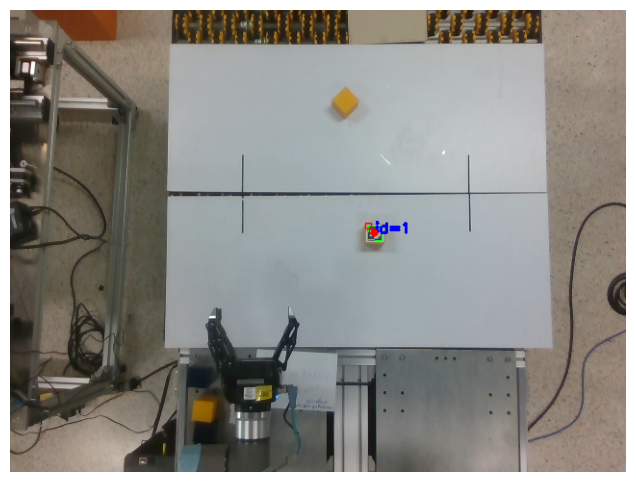

Marker position: [{'id': 1, 'point': Point3D(x=0.137, y=-0.053, z=1.483)}]
Transformed marker position: [{'id': 1, 'point': Point3D(x=0.884, y=0.321, z=-0.113)}]
Transformed marker position: 0.8837228522461421 0.32061694857870515 -0.11285334948969225
End effector position: [0.9337228522461422, 0.12061694857870514, -0.11285334948969225, -1.7318443587261685, 0.686842056802218, -1.7312759524010408]


In [27]:
# Get marker position from cam 
aruco_dict_type = cv.aruco.DICT_5X5_1000
marker_pos = cam.cam_capture_marker_jupyter(aruco_dict_type)
print("Marker position:", marker_pos)
# mutiply with matrix
transfrom_point = cam.transform_marker_points(marker_pos)
print("Transformed marker position:", transfrom_point)
point = transfrom_point[0]["point"]  # Access the first element of the list and then the "point" key.
print("Transformed marker position:", point.x, point.y, point.z)
pos_end = [point.x+0.05, point.y-0.20, point.z] + RPY
print("End effector position:", pos_end)

In [28]:
pos_current = real_robot.robot_get_position()
# pos_end = GOAL
# pos_current = HOME_POS
T_current = SE3(pos_current[0], pos_current[1], pos_current[2]) @ SE3.RPY(pos_current[3], pos_current[4], pos_current[5], unit='rad')

joint_position  = real_robot.robot_get_joint_rad()
print("Current joint position:\n", joint_position)
# joint_position = HOME_POS_JOINTS
robotDH.q = joint_position
T_fk = robotDH.fkine(robotDH.q)
print("FK position:\n", T_fk)

T_end   = SE3(pos_end[0], pos_end[1], pos_end[2]) @ SE3.RPY(pos_end[3], pos_end[4], pos_end[5], unit='rad')

print("Start TCP Pose:\n", T_current)

# compare error between T_fk and T_current
# Calculate RMSE for translation and rotation errors
translation_error = T_fk.t - T_current.t
rotation_error = T_fk.rpy() - T_current.rpy()

rmse_translation = np.sqrt(np.mean(translation_error**2))
rmse_rotation = np.sqrt(np.mean(rotation_error**2))

print("RMSE Translation error between FK and current pose:", rmse_translation)
print("RMSE Rotation error (RPY) between FK and current pose:", rmse_rotation)


Current joint position:
 [0.7144562602043152, -1.9380179844298304, -2.0519907474517822, -2.2720653019347132, -0.9003155867206019, 2.365333080291748]
FK position:
    0.02027   0.04225   0.9989    0.6994    
  -0.7225   -0.69      0.04385   0.1837    
   0.6911   -0.7226    0.01654   0.1702    
   0         0         0         1         

Start TCP Pose:
   -0.1236   -0.05832   0.9906    0.7012    
  -0.7633    0.6435   -0.05732   0.1843    
  -0.6341   -0.7633   -0.124     0.1722    
   0         0         0         1         

RMSE Translation error between FK and current pose: 0.001574492966705215
RMSE Rotation error (RPY) between FK and current pose: 0.8507668736789821


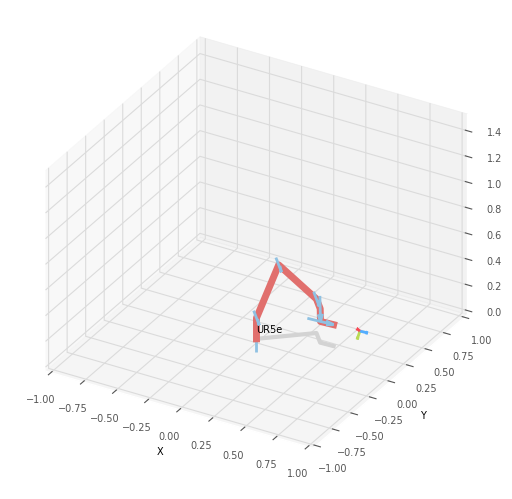

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'UR5e')

<Figure size 640x480 with 0 Axes>

In [29]:
robotDH.plot(joint_position, block=False, limits=[-1, 1, -1, 1, 0, 1.5],vellipse=False)

## Cubic polynomial trajectory planning

In [30]:
# init planning class
planning = Planning()


pos_start = T_current.t   # -> array([x0, y0, z0])
pos_end   = T_end.t       # -> array([x1, y1, z1])
rpy_start = T_current.rpy()  # -> array([roll0, pitch0, yaw0])
rpy_end   = T_end.rpy()      # -> array([roll1, pitch1, yaw1])

waypoints_trans = np.column_stack((pos_start, pos_end)) 
waypoints_rpy = np.column_stack((rpy_start, rpy_end))

d = np.linalg.norm(pos_end - pos_start)
v_tool, a_max = 0.1, 0.5
T_total, profile, ta, tc, td = planning.compute_traj_time_v2(d, v_tool, a_max)


# 2) Build time arrays
timepoints = np.array([0.0, T_total])
dt         = 1/100
num_steps  = int(np.ceil(T_total / dt)) + 1
t_vec      = np.linspace(0.0, T_total, num_steps)


q, qd, qdd, segments = planning.cubicpolytraj(
    waypoints_trans, timepoints, t_vec,
    vel_bc = np.zeros((3,2))
)

# 4) Generate orientation trajectory via SLERP → RPY
# rots    = R.from_euler('xyz', waypoints_rpy.T, degrees=False)
# slerp   = Slerp(timepoints, rots)
# rots_traj = slerp(t_vec)
# rpy_traj = rots_traj.as_euler('xyz', degrees=False).T



# === Pretty Print Log ===
print("\n=== TRAJECTORY SUMMARY ===")
print(f"Profile:            {profile}")
print(f"Total Duration:     {T_total:.3f} s")
print(f"  Acceleration:     {ta:.3f} s")
print(f"  Constant Vel.:    {tc:.3f} s")
print(f"  Deceleration:     {td:.3f} s")

print("\n=== WAYPOINT TIMES ===")
print(f"  Start Time:       {timepoints[0]:.3f} s")
print(f"  End Time:         {timepoints[1]:.3f} s")

print("\n=== SAMPLING ===")
print(f"  Time Step (dt):   {dt:.3f} s")
print(f"  Samples:          {len(t_vec)}")
print(f"  From {t_vec[0]:.3f} to {t_vec[-1]:.3f} s")

print("\n=== TRAJECTORY SHAPES ===")
print(f"  Position:         {q.shape}")
print(f"  Velocity:         {qd.shape}")
print(f"  Acceleration:     {qdd.shape}")
# print(f"  RPY Sequence:     {rpy_traj.shape}")




=== TRAJECTORY SUMMARY ===
Profile:            Trapezoidal
Total Duration:     3.933 s
  Acceleration:     0.200 s
  Constant Vel.:    3.533 s
  Deceleration:     0.200 s

=== WAYPOINT TIMES ===
  Start Time:       0.000 s
  End Time:         3.933 s

=== SAMPLING ===
  Time Step (dt):   0.010 s
  Samples:          395
  From 0.000 to 3.933 s

=== TRAJECTORY SHAPES ===
  Position:         (3, 395)
  Velocity:         (3, 395)
  Acceleration:     (3, 395)


## plotting trajectory

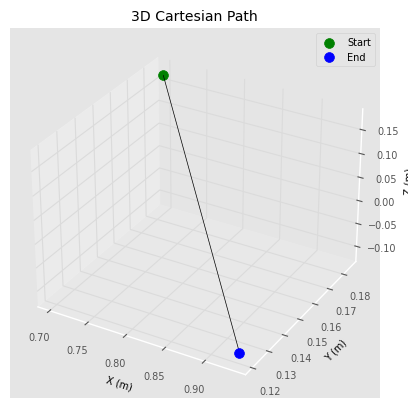

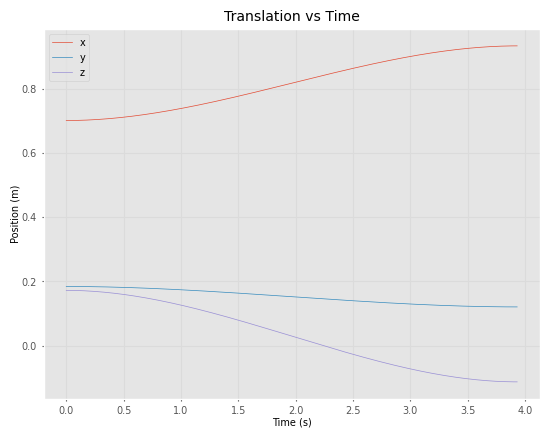

In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# === 1) 3D path of the end‑effector ===
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos_start[0], pos_start[1], pos_start[2], color='green', s=50, label="Start")
ax.scatter(pos_end[0], pos_end[1], pos_end[2], color='blue', s=50, label="End")
ax.plot(
    q[0, :],  # x over time
    q[1, :],  # y over time
    q[2, :],  # z over time
    color='black'
)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('3D Cartesian Path')
ax.legend()
plt.show()

# === 2) X, Y, Z vs time ===
plt.figure()
plt.plot(t_vec, q[0, :], label='x')
plt.plot(t_vec, q[1, :], label='y')
plt.plot(t_vec, q[2, :], label='z')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Translation vs Time')
plt.legend()
plt.show()

# === 3) Roll, Pitch, Yaw vs time ===
# plt.figure()
# plt.plot(t_vec, rpy_traj[0, :], label='roll')
# plt.plot(t_vec, rpy_traj[1, :], label='pitch')
# plt.plot(t_vec, rpy_traj[2, :], label='yaw')
# plt.xlabel('Time (s)')
# plt.ylabel('Angle (rad)')
# plt.title('Orientation (RPY) vs Time')
# plt.legend()
# plt.show()


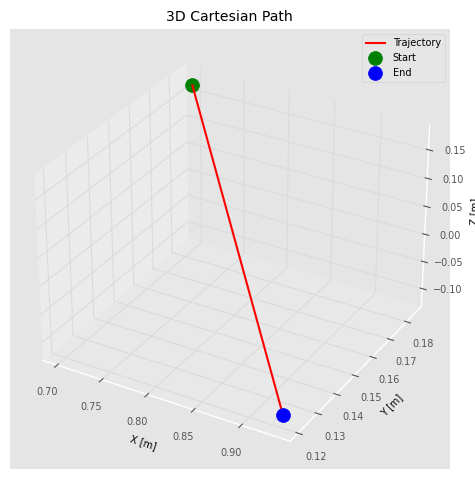

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting

# Assumes you have:
#   q         : array shape (3, M) of your interpolated positions
#   pos_start : array [x0, y0, z0]
#   pos_end   : array [x1, y1, z1]
#   t_vec     : array of length M of your time samples

# Build an (M,3) array of positions from q:
positions = q.T  # now positions[k] = [x_k, y_k, z_k]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot trajectory line
ax.plot(
    positions[:, 0], positions[:, 1], positions[:, 2],
    color='red', linewidth=1.5, label="Trajectory"
)

# Start/end markers
ax.scatter(*pos_start, color='green', s=100, label="Start")
ax.scatter(*pos_end,   color='blue',  s=100, label="End")

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.set_title('3D Cartesian Path')
ax.legend()
plt.tight_layout()
plt.show()


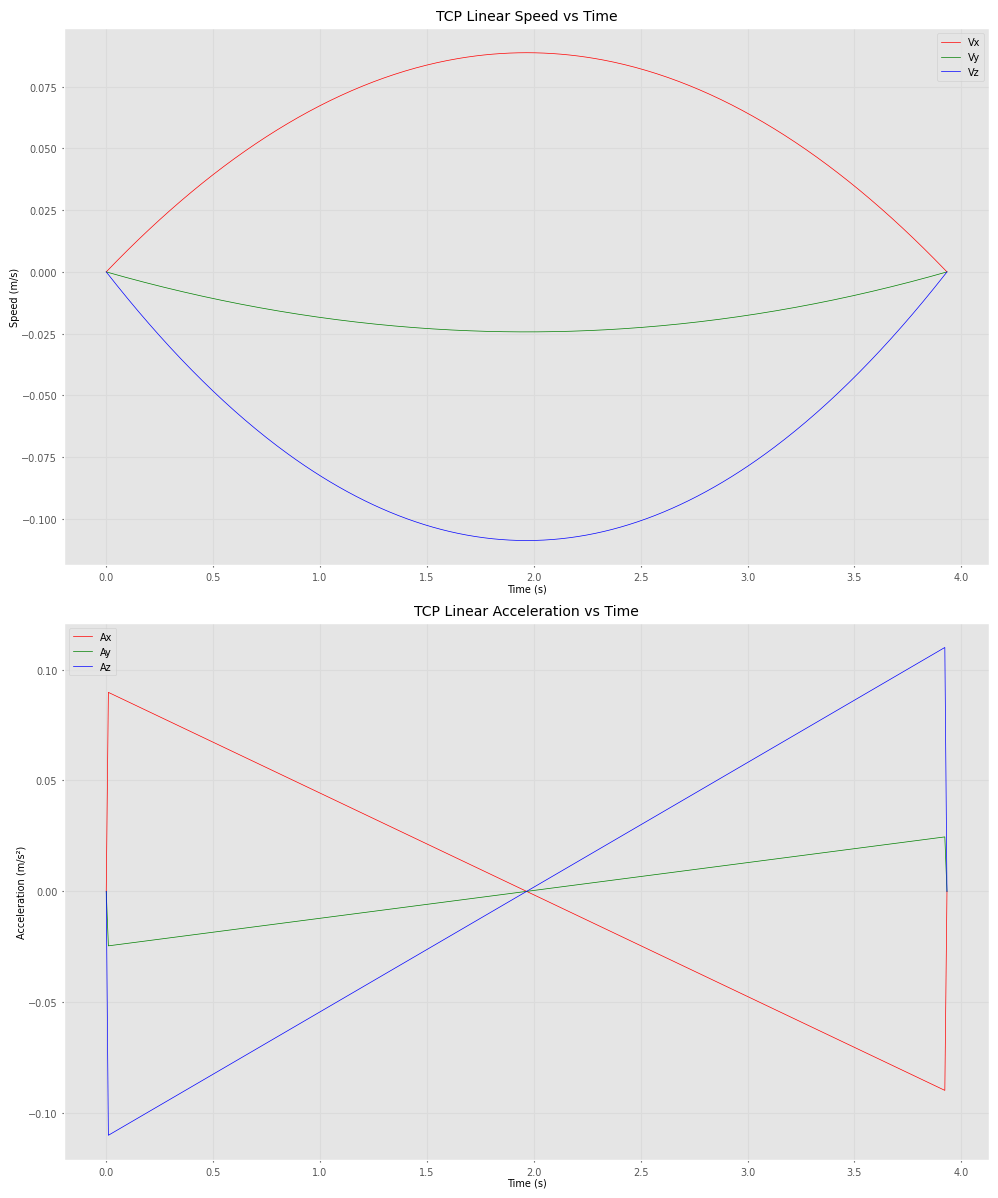

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Assumes the following are defined:
# qd         : (3, M) array of linear velocities from cubicpolytraj
# qdd        : (3, M) array of linear accelerations from cubicpolytraj
# rpy_traj   : (3, M) array of roll/pitch/yaw over time
# t_vec      : (M,) array of time samples
# dt         : time step between samples

# 1) Prepare data arrays
linear_speed = qd.T        # shape (M, 3)
linear_acc   = qdd.T       # shape (M, 3)

# Compute angular speed by differentiating RPY
# rpy = rpy_traj.T           # shape (M, 3)
# rpy_dot = np.vstack((np.zeros((1,3)), np.diff(rpy, axis=0))) / dt
# angular_speed = rpy_dot    # shape (M, 3)

# 2) Plotting
plt.figure(figsize=(10, 12))

# -- Linear Speed --
plt.subplot(2, 1, 1)
plt.plot(t_vec, linear_speed[:, 0], 'r', label='Vx')
plt.plot(t_vec, linear_speed[:, 1], 'g', label='Vy')
plt.plot(t_vec, linear_speed[:, 2], 'b', label='Vz')
plt.title('TCP Linear Speed vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')
plt.legend()
plt.grid(True)

# -- Angular Speed --
# plt.subplot(3, 1, 2)
# plt.plot(t_vec, angular_speed[:, 0], 'r', label='ω_roll')
# plt.plot(t_vec, angular_speed[:, 1], 'g', label='ω_pitch')
# plt.plot(t_vec, angular_speed[:, 2], 'b', label='ω_yaw')
# plt.title('TCP Angular Speed vs Time')
# plt.xlabel('Time (s)')
# plt.ylabel('Angular Speed (rad/s)')
# plt.legend()
# plt.grid(True)

# -- Linear Acceleration --
plt.subplot(2, 1, 2)
plt.plot(t_vec, linear_acc[:, 0], 'r', label='Ax')
plt.plot(t_vec, linear_acc[:, 1], 'g', label='Ay')
plt.plot(t_vec, linear_acc[:, 2], 'b', label='Az')
plt.title('TCP Linear Acceleration vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## REAL robot trajectory planning

In [18]:
import numpy as np

# === Assumes you have ===
# q             : (3, M) array of Cartesian positions
# rpy_traj      : (3, M) array of roll/pitch/yaw over time
# real_robot    : your robot interface with method robot_get_ik(pose6)
#                which takes [x,y,z,roll,pitch,yaw] and returns joint angles list or None

# Preallocate joint trajectory list
joint_trajectory = []
tcp_trajectory = []

# Iterate through each sample
M = q.shape[1]
for idx in range(M):
    # Extract position (x,y,z) and orientation (roll,pitch,yaw)
    pos = q[:, idx].tolist()
    ori = rpy_traj[:, idx].tolist()
    
    # Build the 6‑element pose vector
    tcp_pose = pos + ori  # [x, y, z, roll, pitch, yaw]
    tcp_trajectory.append(tcp_pose)
    
    # Solve IK
    q_joint = real_robot.robot_get_ik(tcp_pose)
    
    if q_joint is None:
        raise RuntimeError(f"IK failed at index {idx}, pose = {tcp_pose}")
    
    joint_trajectory.append(q_joint)

# Verify completeness
if len(joint_trajectory) != M:
    raise RuntimeError("Incomplete joint trajectory - some IK solutions failed.")

print(f"Computed joint trajectory for {M} points.")

print("Joint trajectory:")
print(joint_trajectory[-1])


Computed joint trajectory for 395 points.
Joint trajectory:
[0.11348571803013352, -2.8912122834805665, -1.0593282668815736, -2.3229281691291632, -2.10069071508652, 2.386371494259746]


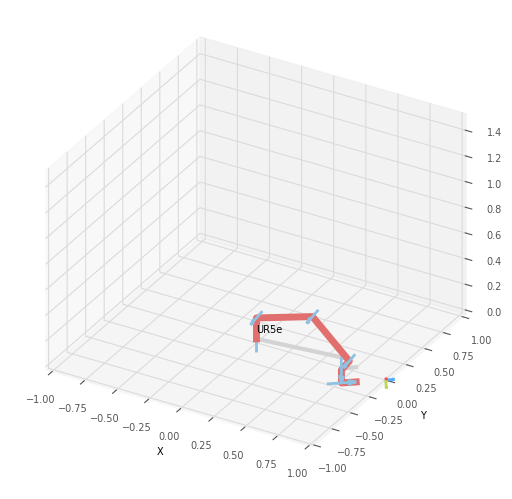

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'UR5e')

<Figure size 640x480 with 0 Axes>

In [19]:
robotDH.plot(joint_trajectory[-1], block=False, limits=[-1, 1, -1, 1, 0, 1.5],vellipse=False)

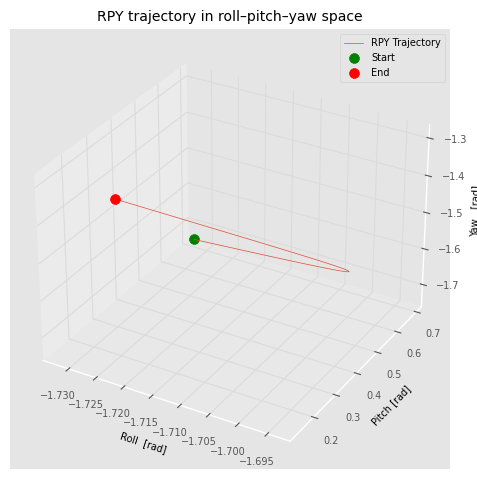

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # noqa: F401 – registers 3‑D projection

# rpy_traj is (3, N):  [roll; pitch; yaw]
roll, pitch, yaw = rpy_traj               # unpack rows

fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')

# Plot the trajectory
ax.plot(roll, pitch, yaw, label="RPY Trajectory")  # one continuous line

# Add start and end points
ax.scatter(roll[0], pitch[0], yaw[0], color='green', s=50, label="Start")
ax.scatter(roll[-1], pitch[-1], yaw[-1], color='red', s=50, label="End")

ax.set_xlabel('Roll  [rad]')
ax.set_ylabel('Pitch [rad]')
ax.set_zlabel('Yaw   [rad]')
ax.set_title('RPY trajectory in roll–pitch–yaw space')
ax.legend()
plt.tight_layout()
plt.show()


=== Begin trajectory control loop (speedJ) ===
[000] t=0.001s | dq = [0. 0. 0. 0. 0. 0.]
[001] t=0.013s | dq = [-0.07404602  0.03850534 -0.01116941 -0.08993957 -0.20104753  0.20387003]
[002] t=0.024s | dq = [-0.07612745  0.03460007 -0.00987108 -0.08650187 -0.20324303  0.20292446]
[003] t=0.035s | dq = [-0.0781972   0.03070574 -0.00857248 -0.0830804  -0.2054261   0.20198577]
[004] t=0.046s | dq = [-0.08025505  0.02682245 -0.00727326 -0.07967559 -0.20759653  0.20105394]
[005] t=0.058s | dq = [-0.08230076  0.02295029 -0.00597304 -0.07628787 -0.20975408  0.20012894]
[006] t=0.069s | dq = [-0.08433412  0.01908937 -0.00467147 -0.07291765 -0.21189853  0.19921073]
[007] t=0.080s | dq = [-0.08635491  0.01523981 -0.00336818 -0.06956536 -0.21402966  0.19829928]
[008] t=0.091s | dq = [-0.0883629   0.0114017  -0.00206285 -0.0662314  -0.21614726  0.19739456]
[009] t=0.102s | dq = [-0.09035787  0.00757517 -0.00075512 -0.0629162  -0.2182511   0.19649654]
[010] t=0.114s | dq = [-0.09233962  0.00376033 

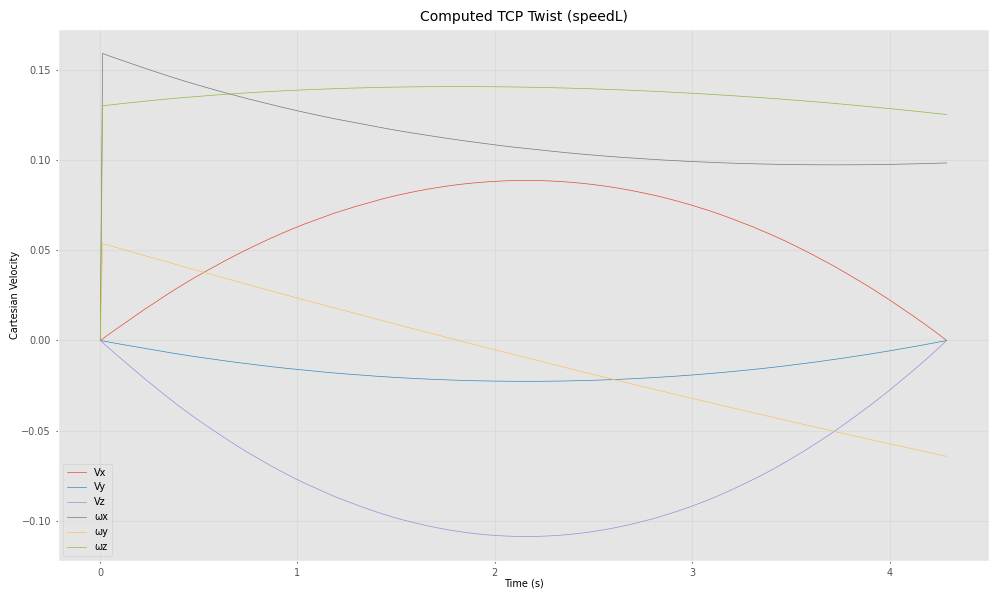

In [14]:
import time
import numpy as np
from spatialmath.base.transforms3d import rpy2jac

def damped_pinv(J, λ=0.02):
    JJt = J @ J.T
    return J.T @ np.linalg.inv(JJt + (λ**2)*np.eye(J.shape[0]))

# … assume qd, rpy_traj, dt, joint_trajectory, robotDH, real_robot defined …

joint_acceleration = 0.5  # rad/s²
time_stamps = []
start_time = time.time()
M = qd.shape[1]
computed_twists = []   # for plotting

# Precompute RPY rates
rpy     = rpy_traj.T
rpy_dot = np.vstack((np.zeros((1,3)), np.diff(rpy, axis=0))) / dt

print("=== Begin trajectory control loop (speedJ) ===")
for i in range(M):
    now = time.time() - start_time
    time_stamps.append(now)

    # 1) Build Cartesian twist
    v_lin = qd[:, i]
    J_rpy = rpy2jac(rpy[i], order='xyz')    # 3×3
    v_ang = J_rpy @ rpy_dot[i]
    twist = np.hstack((v_lin, v_ang))

    # 2) IK: damped pseudo‑inverse to get joint speeds
    q_current = joint_trajectory[i]
    J6 = robotDH.jacob0(q_current)
    dq = np.linalg.inv(J6) @ twist
    computed_twists.append(twist)

    print(f"[{i:03d}] t={now:.3f}s | dq = {dq}")

    # 3) Send via your robot_speed_J
    #    velocity:list, acceleration:float, time:Optional[float]
    # real_robot.robot_speed_J(dq.tolist(), joint_acceleration, dt)

    time.sleep(dt)

print("=== End trajectory control loop ===")


# === Plot the commanded twists ===
computed_twists = np.vstack(computed_twists)  # (M,6)
plt.figure(figsize=(10,6))
labels = ['Vx','Vy','Vz','ωx','ωy','ωz']
for j in range(6):
    plt.plot(time_stamps, computed_twists[:, j], label=labels[j])
plt.xlabel("Time (s)")
plt.ylabel("Cartesian Velocity")
plt.title("Computed TCP Twist (speedL)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


=== Begin trajectory control loop ===
[000] t=0.000s | twist = [0. 0. 0. 0. 0. 0.]
[000] cond(J) = 8.92e+00
[000] dq = [0. 0. 0. 0. 0. 0.]

[001] t=0.012s | twist = [ 0.00090019 -0.0002297  -0.00110248  0.15941235  0.05379961  0.1303744 ]
[001] cond(J) = 8.91e+00
[001] dq = [-0.07404602  0.03850534 -0.01116941 -0.08993957 -0.20104753  0.20387003]

[002] t=0.024s | twist = [ 0.00179581 -0.00045823 -0.00219936  0.15896618  0.05345326  0.13051672]
[002] cond(J) = 8.91e+00
[002] dq = [-0.07612745  0.03460007 -0.00987108 -0.08650187 -0.20324303  0.20292446]

[003] t=0.035s | twist = [ 0.00268684 -0.0006856  -0.00329062  0.15852237  0.0531071   0.13065789]
[003] cond(J) = 8.91e+00
[003] dq = [-0.0781972   0.03070574 -0.00857248 -0.0830804  -0.2054261   0.20198577]

[004] t=0.046s | twist = [ 0.00357329 -0.00091179 -0.00437627  0.15808091  0.05276116  0.13079791]
[004] cond(J) = 8.91e+00
[004] dq = [-0.08025505  0.02682245 -0.00727326 -0.07967559 -0.20759653  0.20105394]

[005] t=0.058s | twi

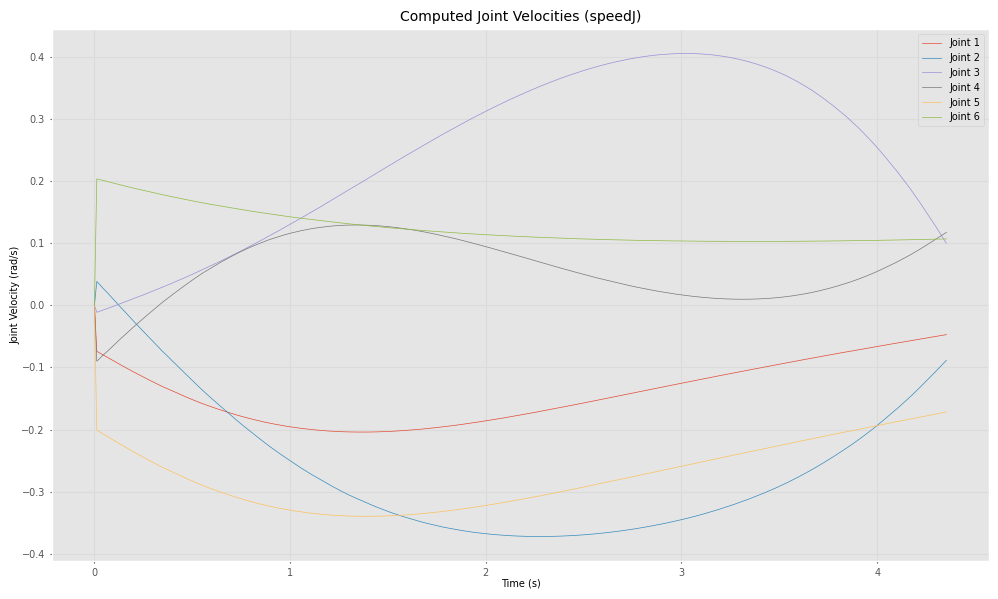

In [16]:



import time
import numpy as np
import matplotlib.pyplot as plt
from spatialmath.base.transforms3d import rpy2jac

# === Prerequisites ===
# q             : (3, M) array of Cartesian positions
# qd            : (3, M) array of Cartesian velocities
# qdd           : (3, M) array of Cartesian accelerations
# rpy_traj      : (3, M) array of roll/pitch/yaw over time
# t_vec         : (M,)   array of time samples
# dt            : control loop timestep, e.g. t_vec[1] - t_vec[0]
# joint_trajectory : list of length M of joint vectors from your IK loop
# robotDH       : object with method jacob0(q) → 6×6 Jacobian
# real_robot    : interface with method robot_speed_J(joint_vels, acceleration, time)

joint_acceleration = 0.5  # rad/s²

computed_joint_velocities = []
time_stamps = []
start_time   = time.time()

M = q.shape[1]

# Prepare RPY and RPY rates
rpy     = rpy_traj.T
rpy_dot = np.vstack((np.zeros((1,3)), np.diff(rpy, axis=0))) / dt

print("=== Begin trajectory control loop ===")
for i in range(M):
    now = time.time() - start_time
    time_stamps.append(now)

    v_lin = qd[:, i]
    J_rpy = rpy2jac(rpy[i], order='xyz')
    v_ang = J_rpy @ rpy_dot[i]
    twist = np.hstack((v_lin, v_ang))

    # Debug print
    print(f"[{i:03d}] t={now:.3f}s | twist = {twist}")

    # 4) Inverse kinematics via damped‐pinv of spatial Jacobian
    q_current = joint_trajectory[i]
    J6 = robotDH.jacob0(q_current)          # 6×6
    condJ = np.linalg.cond(J6)
    print(f"[{i:03d}] cond(J) = {condJ:.2e}")
    if condJ > 1e6:
        print(f"[{i:03d}] WARNING: Jacobian ill‐conditioned, aborting")
        break

    dq = np.linalg.inv(J6) @ twist
    print(f"[{i:03d}] dq = {dq}\n")

    computed_joint_velocities.append(dq)

    # 5) Send to robot
    real_robot.robot_speed_J(dq.tolist(), acceleration=joint_acceleration, time=dt)

    time.sleep(dt)

print("=== End trajectory control loop ===")

# Convert list→array for plotting
computed_joint_velocities = np.vstack(computed_joint_velocities)  # (M, n_joints)

# === Plot ===
plt.figure(figsize=(10,6))
for j in range(computed_joint_velocities.shape[1]):
    plt.plot(time_stamps, computed_joint_velocities[:, j], label=f'Joint {j+1}')
plt.xlabel("Time (s)")
plt.ylabel("Joint Velocity (rad/s)")
plt.title("Computed Joint Velocities (speedJ)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
real_robot.robot_move_speed_stop()
tcp_pose_goal = real_robot.robot_get_position()
print("Current pose after speedJ command:", tcp_pose_goal)
# cahnge rpy
pos_current_goal = tcp_pose_goal[:3]+ RPY_test
print("Current pose after speedJ command:", pos_current_goal)
real_robot.robot_moveL(pos_current_goal, speed=0.1, acceleration=0.5)



In [ ]:
real_robot.robo_move_home()
real_robot.robot_release()